Due to difficulties converting a Pytorch model to a Tensorflow model, this notebook uses the same CNN model as before, but written in Tensorflow. This allows it to be portable to an Android device.

In [1]:
# imports 
import numpy as np
from math import ceil, isnan
from scipy import signal
from scipy.io import wavfile
import os
import os.path as path
import librosa
from IPython.display import Audio
from PIL import Image

import build.pybind_modules.dsp_module as cu
import build.pybind_modules.matrix_module as myMatrix

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from tensorflow.keras.models import Model
from tensorflow.math import confusion_matrix

from tflite_runtime.interpreter import Interpreter

print('TensorFlow version:',tf.__version__)
physical_devices = tf.config.list_physical_devices()
for dev in physical_devices:
    print(dev)

2023-05-04 23:49:07.729235: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 23:49:07.730501: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 23:49:07.754057: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 23:49:07.754560: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 23:49:08.154836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

TensorFlow version: 2.12.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


2023-05-04 23:49:08.924555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-04 23:49:08.926255: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
# Parameters 
MODEL_NAME = 'audio_mnist'
EPOCHS = 20
BATCH_SIZE = 64

# Parameters used on tablet 
VOICED_THRESHOLD = 20000000
FRAME_SETBACK = 2
FS = 48000
DOWN_SAMPLED_FS = 8000
NFFT = 256
NOVERLAP = -1
NFILT = 40
NUM_CEPS = 13
NN_DATA_COLS = 28
NN_DATA_ROWS = 12
PREEMPHASIS_B = 0.97
PIXEL_WIDTH = 400
PIXEL_HEIGHT = 300

In [3]:
""" helper functions used in sample processing before feed the samples to the CNN """
def soundDataToFloat(SD):
    "Converts integer representation back into librosa-friendly floats, given a numpy array SD"
    return np.array([ np.float32(s/32768.0) for s in SD])

def soundDataToInt16(SD):
    return np.array( [np.int16(s*32768.0) for s in SD] )

def createButter(N, Wn, fs):
    num, den = signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=fs)
    return np.array([num[i]/den[i] for i in range(len(num))])

def createFIR(num_taps, cut_off, fs):
    return signal.firwin(num_taps, cut_off, fs=fs)

def displayFIR(filt):
    coef_str = "{" 
    for val in filt: 
        coef_str += str(val) + ", " 
    coef_str = coef_str[:-2] 
    coef_str += "};" 
    print("FIR a Coefficients")
    print(coef_str) 

def applyFIR(samples, filt):
    circBuf = np.zeros(len(filt))
    circBufIdx = 0
    filteredSamples = np.zeros(len(samples))
    num_taps = len(filt)

    for i in range(len(samples)):
        circBuf[circBufIdx] = samples[i]
        curr_val = 0

        for n in range(num_taps):
            curr_val += filt[n] * circBuf[ (((circBufIdx - n) % num_taps) + num_taps) % num_taps]

        filteredSamples[i] = curr_val 
        circBufIdx = (circBufIdx + 1) % num_taps

    return filteredSamples

def frameVoiced(frame, threshold):
    isVoiced = False
    sum = 0
    for i in range(len(frame)):
        sum += abs(frame[i])**2

    if (sum > threshold):
        isVoiced = 1
    
    return isVoiced

def trimSamples(samples, frameSize, nfft, noverlap, threshold, frame_setback):
    num_samples = len(samples)
    if (noverlap < 0):
        noverlap = int(nfft/2)

    step = nfft - noverlap

    numFrames = ceil(num_samples / step)

    while ((numFrames - 1)*step + (nfft - 1) >= num_samples):
        numFrames -= 1

    first_frame = 0
    for i in range(numFrames):
        if frameVoiced(soundDataToInt16(samples[i*step:i*step + nfft]), threshold=threshold):
            first_frame = i
            break
    
    first_frame -= frame_setback
    if first_frame < 0:
        first_frame = 0
    last_frame = first_frame + frameSize
    num_trimmed_samples = ((last_frame - 1)*step + nfft) - (first_frame*step)
    trimmed_samples = np.zeros(num_trimmed_samples)

    for i in range(num_trimmed_samples):
        if (first_frame*step + i >= len(samples)):
            break
        trimmed_samples[i] = samples[first_frame*step + i]

    return trimmed_samples

def createImage(data, pixel_width, pixel_height, data_rows, data_cols, filename=None):
    def hex_to_rgb(val):
        mask = 0x0000FF
        b = mask & val
        g = mask & (val >> 8)
        r = mask & (val >> 16)
        
        return (r,g,b)

    viridis_pallete = [
        0x440154,
        0x481567,
        0x482677,
        0x453771,
        0x404788,
        0x39568C,
        0x33638D,
        0x2D708E,
        0x287D8E,
        0x238A8D,
        0x1F968B,
        0x20A387,
        0x29AF7F,
        0x3CBB75,
        0x55C667,
        0x73D055,
        0x95D840,
        0xB8DE29,
        0xDCE319,
        0xFDE725
    ]
    viridis_pallete_rgb = [hex_to_rgb(x) for x in viridis_pallete]
    viridis_size = len(viridis_pallete_rgb)

    max_val = None
    min_val = None
    for y in range(data_rows):
        for x in range(data_cols):
            sample = data[y,x]
            if isnan(sample):
                sample = 0
                data[y,x] = sample
            if max_val == None or sample > max_val:
                max_val = sample
            if min_val == None or sample < min_val:
                min_val = sample

    max_val -= min_val
    data = (data-min_val) / max_val

    """ canvas for holding rgb image from the range 0 to 255 """
    canvas = np.zeros((pixel_height, pixel_width, 3), dtype=np.uint8)
    horizontal_step = int(pixel_width / data_cols)
    vertical_step = int(pixel_height / data_rows)

    # attempting to only manipulate green in rgb

    # step counters that are 1 indexed
    horizontal_count = 1
    vertical_count = 1
    for pixel_row in range(pixel_height):
        if (pixel_row >= vertical_count * vertical_step) and (vertical_count < data_rows):
            vertical_count += 1

        horizontal_count = 1
        for pixel_col in range(pixel_width):
            if (pixel_col >= horizontal_count * horizontal_step) and (horizontal_count < data_cols):
                horizontal_count += 1
            
            # 0 index
            x_idx = horizontal_count - 1
            y_idx = data_rows - vertical_count

            # determine green value from data
            percent = data[y_idx, x_idx]

            viridis_idx = int((viridis_size-1) * percent)
            curr_color = viridis_pallete_rgb[viridis_idx]

            red_val = curr_color[0]
            green_val = curr_color[1]
            blue_val = curr_color[2]
            
            canvas[pixel_row, pixel_col, 0] = red_val
            canvas[pixel_row, pixel_col, 1] = green_val
            canvas[pixel_row, pixel_col, 2] = blue_val

    im = Image.fromarray(canvas)
    if filename is not None:
        im.save(filename) # if you wanted to save the image

    return im

In [4]:
def relu6(x):
    return tf.keras.activations.relu(x, max_value=6)


class NeuralNet(tf.keras.Model):
    def __init__(self, out_size):
        super(NeuralNet, self).__init__()
        self.rescaling = tf.keras.layers.Rescaling(1./255, input_shape=(300, 400, 3))
        self.conv1 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), activation=relu6, padding='same', kernel_initializer='he_uniform')
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation=relu6, padding='same', kernel_initializer='he_uniform')
        self.dropout_1 = tf.keras.layers.Dropout(rate=0.1)
        self.dropout_2 = tf.keras.layers.Dropout(rate=0.16)
        self.dropout_3 = tf.keras.layers.Dropout(rate=0.12)

        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(units=5000, activation='relu', kernel_initializer='he_uniform')
        self.dense_2 = tf.keras.layers.Dense(units=1000, activation='relu', kernel_initializer='he_uniform')
        self.dense_3 = tf.keras.layers.Dense(units=out_size, activation='softmax', kernel_initializer='he_uniform')

        # self.loss_fn = loss_fn
        # self.optimizer = tf.keras.optimizers.SGD(learning_rate=lrate, momentum=0.9, weight_decay=weight_decay)

    def call(self, x):
        x = self.rescaling(x)
        # print("Done rescaling")
        x = self.conv1(x)
        # print("Done conv1")
        x = self.maxpool(x)
        # print("Done maxpool1")
        x = self.conv2(x)
        # print("Done conv2")
        x = self.maxpool(x)
        # print("Done maxpool2")
        x = self.dropout_1(x, training=True)
        # print("Done droput1")
        x = self.flatten(x)
        # print("Done flatten")
        x = self.dense_1(x)
        # print("Done dense 1")
        x = self.dropout_2(x, training=True)
        # print("Done dropout 2")
        x = self.dense_2(x)
        # print("Done dense 3")
        x = self.dropout_3(x, training=True)
        # print("Done dropout 3")
        x = self.dense_3(x)
        # print("Done dense 3")
        return x

(300, 400, 4)


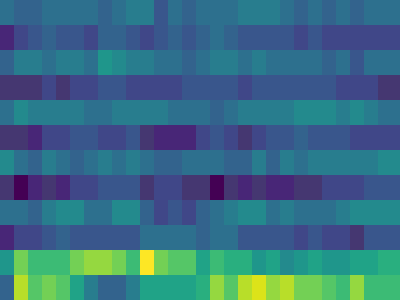

0x33
0x63
0x8d
0xff


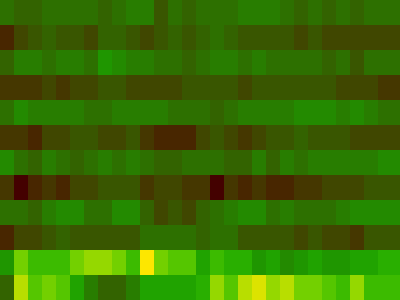

In [5]:
# Checking the data set

path = "MFCC_Images/0/mfcc_images/Mon May 01 14:35:23 CDT 2023_mfcc.png"
test_image = Image.open(path)
image_data = np.array(test_image)
print(image_data.shape)
display(test_image)

for i in range(4):
    print("{}".format(hex(image_data[10][20][i])))

""" 
Noticed that the fourth channel is alpha which is always xFF.
Now I will try to figure out the RGB order by mutating the image.
"""
for i in range(image_data.shape[0]):
    for j in range(image_data.shape[1]):
        pixel = image_data[i,j]
        pixel[2] = 0
"""
From experimentation:
    channel 0 -- r
    channel 1 -- g
    channel 2 -- b
    channel 3 -- alpha (always 0xFF) (also must be the most signicant byte)

This is good because it verifies that the breakdown is the same as the images on the Android tablet. 
"""
# now figure out which channel is green
mutated_image = Image.fromarray(image_data)
display(mutated_image)

## Jorge's Voice
Run this block of code for training on Jorge's dataset

In [13]:
# Loading the dataset
train_files_per_label = 50
dev_files_per_label = 60 - train_files_per_label
dev_set = np.zeros((dev_files_per_label*10, 300, 400, 3), dtype=np.int8)
dev_set_labels = np.zeros(dev_files_per_label * 10)
raw_train_set = np.zeros((train_files_per_label*10, 300, 400, 4), dtype=np.int8)
train_set_labels = np.zeros(train_files_per_label * 10)

path = os.getcwd() + "/MFCC_Images"
labeled_directories = os.listdir(path)

for i in range(len(labeled_directories)):
    label = labeled_directories[i]
    curr_label = int(label)
    # print(curr_label)

    image_directory_path = f"{path}/{label}/mfcc_images"
    image_directory = os.listdir(image_directory_path)
    
    for j in range(len(image_directory)):
        image = image_directory[j]
        image_path = f"{image_directory_path}/{image}"
        curr_image = Image.open(image_path)
        if j < train_files_per_label:
            raw_train_set[(i*train_files_per_label) + j,:,:,:3] = np.array(curr_image)[:,:,:3]
            raw_train_set[(i*train_files_per_label) + j,:,:,3] = curr_label
        else:
            dev_set[(i*dev_files_per_label) + (j - train_files_per_label)] = np.array(curr_image)[:,:,:3]
            dev_set_labels[(i*dev_files_per_label) + (j - train_files_per_label)] = curr_label

# now randomize the training set
# note that this only shuffles along axis=0 which is what we want
print("before shuffle shape: {}".format(raw_train_set.shape))
np.random.shuffle(raw_train_set)
print("after shuffle shape: {}".format(raw_train_set.shape))
train_set_label_idx = 0
for i in range(raw_train_set.shape[0]):
    train_set_labels[train_set_label_idx] = raw_train_set[i,0,0,3]
    train_set_label_idx += 1
train_set = np.zeros((train_files_per_label*10, 300, 400, 3), dtype=np.int8)
train_set[:,:,:,:] = raw_train_set[:,:,:,:3]

print("len train set: {}".format(len(train_set)))
print("len train label set: {}".format(len(train_set_labels)))
print("len dev set: {}".format(len(dev_set)))
print("len dev label set: {}".format(len(dev_set_labels)))

print(train_set_labels)

before shuffle shape: (500, 300, 400, 4)
after shuffle shape: (500, 300, 400, 4)
len train set: 500
len train label set: 500
len dev set: 100
len dev label set: 100
[3. 5. 7. 0. 5. 2. 7. 2. 0. 1. 8. 6. 9. 9. 8. 3. 3. 8. 4. 5. 9. 9. 8. 7.
 5. 0. 7. 8. 0. 5. 6. 5. 0. 3. 4. 2. 8. 5. 8. 4. 3. 1. 9. 9. 7. 5. 3. 4.
 9. 6. 8. 2. 7. 5. 3. 9. 0. 5. 1. 7. 9. 4. 3. 4. 6. 1. 8. 0. 0. 5. 9. 7.
 0. 5. 4. 6. 4. 8. 1. 2. 2. 7. 6. 4. 3. 0. 1. 3. 8. 6. 4. 3. 0. 8. 9. 3.
 4. 8. 9. 6. 2. 6. 9. 5. 4. 0. 0. 6. 1. 5. 1. 2. 2. 3. 3. 9. 3. 4. 2. 7.
 0. 4. 7. 7. 1. 5. 4. 2. 7. 4. 7. 5. 8. 1. 9. 6. 6. 1. 0. 9. 0. 8. 3. 7.
 0. 6. 2. 0. 9. 8. 5. 7. 2. 8. 2. 0. 5. 7. 8. 0. 0. 0. 5. 1. 1. 8. 2. 1.
 9. 1. 6. 2. 7. 7. 7. 9. 7. 1. 9. 6. 6. 2. 4. 0. 6. 6. 8. 6. 6. 8. 1. 3.
 5. 6. 9. 0. 0. 4. 7. 2. 8. 5. 9. 7. 5. 3. 2. 8. 6. 3. 2. 2. 1. 9. 3. 3.
 1. 0. 1. 8. 1. 4. 1. 3. 4. 3. 1. 2. 9. 7. 7. 4. 8. 7. 6. 2. 1. 5. 8. 7.
 8. 7. 4. 0. 6. 3. 4. 1. 5. 4. 4. 1. 8. 3. 7. 9. 5. 1. 3. 2. 6. 5. 2. 6.
 1. 8. 2. 4. 2. 0. 5. 0. 7. 3. 2

## Jorge's Voice (GPU)

In [7]:
# Loading the dataset
train_files_per_label = 50
dev_files_per_label = 60 - train_files_per_label
dev_set = np.zeros((dev_files_per_label*10, 300, 400, 3), dtype=np.int8)
dev_set_labels = np.zeros(dev_files_per_label * 10)
raw_train_set = np.zeros((train_files_per_label*10, 300, 400, 4), dtype=np.int8)
train_set_labels = np.zeros(train_files_per_label * 10)

path = os.getcwd() + "/MFCC_Images"
labeled_directories = os.listdir(path)

for i in range(len(labeled_directories)):
    label = labeled_directories[i]
    curr_label = int(label)
    # print(curr_label)

    image_directory_path = f"{path}/{label}/gpu_images"
    image_directory = os.listdir(image_directory_path)
    
    for j in range(len(image_directory)):
        image = image_directory[j]
        image_path = f"{image_directory_path}/{image}"
        curr_image = Image.open(image_path)
        if j < train_files_per_label:
            raw_train_set[(i*train_files_per_label) + j,:,:,:3] = np.array(curr_image)[:,:,:3]
            raw_train_set[(i*train_files_per_label) + j,:,:,3] = curr_label
        else:
            dev_set[(i*dev_files_per_label) + (j - train_files_per_label)] = np.array(curr_image)[:,:,:3]
            dev_set_labels[(i*dev_files_per_label) + (j - train_files_per_label)] = curr_label

# now randomize the training set
# note that this only shuffles along axis=0 which is what we want
print("before shuffle shape: {}".format(raw_train_set.shape))
np.random.shuffle(raw_train_set)
print("after shuffle shape: {}".format(raw_train_set.shape))
train_set_label_idx = 0
for i in range(raw_train_set.shape[0]):
    train_set_labels[train_set_label_idx] = raw_train_set[i,0,0,3]
    train_set_label_idx += 1
train_set = np.zeros((train_files_per_label*10, 300, 400, 3), dtype=np.int8)
train_set[:,:,:,:] = raw_train_set[:,:,:,:3]

print("len train set: {}".format(len(train_set)))
print("len train label set: {}".format(len(train_set_labels)))
print("len dev set: {}".format(len(dev_set)))
print("len dev label set: {}".format(len(dev_set_labels)))

print(train_set_labels)

before shuffle shape: (500, 300, 400, 4)
after shuffle shape: (500, 300, 400, 4)
len train set: 500
len train label set: 500
len dev set: 100
len dev label set: 100
[5. 8. 4. 0. 8. 1. 2. 3. 3. 9. 6. 0. 8. 1. 8. 5. 3. 4. 2. 6. 1. 0. 2. 3.
 6. 7. 2. 2. 4. 5. 6. 1. 7. 5. 4. 8. 1. 0. 2. 3. 9. 5. 6. 8. 0. 2. 6. 0.
 1. 0. 7. 0. 9. 1. 1. 7. 9. 9. 5. 3. 4. 3. 4. 1. 9. 5. 6. 5. 4. 6. 3. 9.
 4. 4. 9. 3. 2. 3. 5. 4. 7. 7. 7. 9. 8. 6. 6. 2. 4. 1. 6. 5. 6. 6. 6. 4.
 0. 5. 6. 9. 9. 0. 2. 2. 9. 9. 8. 6. 3. 4. 1. 9. 6. 7. 0. 7. 1. 0. 4. 3.
 4. 3. 8. 6. 1. 2. 5. 5. 8. 1. 7. 8. 1. 0. 7. 4. 4. 8. 8. 6. 1. 9. 5. 2.
 3. 3. 8. 6. 0. 6. 8. 2. 3. 9. 9. 5. 1. 0. 6. 0. 0. 1. 8. 3. 5. 7. 5. 7.
 9. 9. 3. 9. 2. 8. 1. 1. 5. 3. 4. 1. 5. 2. 7. 6. 5. 3. 3. 4. 3. 5. 7. 8.
 2. 1. 4. 9. 0. 4. 9. 1. 2. 8. 5. 5. 9. 3. 1. 5. 3. 5. 6. 7. 0. 2. 7. 1.
 4. 6. 9. 7. 4. 2. 7. 0. 8. 5. 5. 6. 4. 1. 8. 2. 8. 6. 5. 2. 4. 5. 3. 3.
 9. 0. 9. 8. 8. 0. 9. 6. 3. 0. 0. 8. 7. 7. 2. 0. 5. 2. 4. 7. 2. 2. 2. 2.
 6. 4. 3. 4. 2. 4. 7. 5. 2. 5. 8

## Jonathan's Voice
Run this block of code if you want to train a model on Jonathan's data set. 

In [6]:
# Loading the dataset
train_files_per_label = 50
dev_files_per_label = 60 - train_files_per_label
dev_set = np.zeros((dev_files_per_label*10, 300, 400, 3), dtype=np.int8)
dev_set_labels = np.zeros(dev_files_per_label * 10)
raw_train_set = np.zeros((train_files_per_label*10, 300, 400, 4), dtype=np.int8)
train_set_labels = np.zeros(train_files_per_label * 10)

path = os.getcwd() + "/Jonathan_MFCC_Images"
labeled_directories = os.listdir(path)

for i in range(len(labeled_directories)):
    label = labeled_directories[i]
    curr_label = int(label)
    # print(curr_label)

    image_directory_path = f"{path}/{label}/mfcc_images"
    image_directory = os.listdir(image_directory_path)
    
    for j in range(len(image_directory)):
        image = image_directory[j]
        image_path = f"{image_directory_path}/{image}"
        curr_image = Image.open(image_path)
        if j < train_files_per_label:
            raw_train_set[(i*train_files_per_label) + j,:,:,:3] = np.array(curr_image)[:,:,:3]
            raw_train_set[(i*train_files_per_label) + j,:,:,3] = curr_label
        else:
            dev_set[(i*dev_files_per_label) + (j - train_files_per_label)] = np.array(curr_image)[:,:,:3]
            dev_set_labels[(i*dev_files_per_label) + (j - train_files_per_label)] = curr_label

# now randomize the training set
# note that this only shuffles along axis=0 which is what we want
print("before shuffle shape: {}".format(raw_train_set.shape))
np.random.shuffle(raw_train_set)
print("after shuffle shape: {}".format(raw_train_set.shape))
train_set_label_idx = 0
for i in range(raw_train_set.shape[0]):
    train_set_labels[train_set_label_idx] = raw_train_set[i,0,0,3]
    train_set_label_idx += 1
train_set = np.zeros((train_files_per_label*10, 300, 400, 3), dtype=np.int8)
train_set[:,:,:,:] = raw_train_set[:,:,:,:3]

print("len train set: {}".format(len(train_set)))
print("len train label set: {}".format(len(train_set_labels)))
print("len dev set: {}".format(len(dev_set)))
print("len dev label set: {}".format(len(dev_set_labels)))

print(train_set_labels)

before shuffle shape: (500, 300, 400, 4)
after shuffle shape: (500, 300, 400, 4)
len train set: 500
len train label set: 500
len dev set: 100
len dev label set: 100
[3. 1. 1. 9. 3. 2. 2. 6. 6. 6. 2. 8. 0. 8. 3. 3. 8. 7. 2. 9. 8. 9. 9. 1.
 9. 8. 3. 0. 8. 2. 8. 8. 7. 7. 6. 3. 4. 6. 9. 1. 5. 0. 0. 7. 1. 4. 5. 5.
 4. 6. 4. 6. 4. 7. 1. 7. 8. 9. 7. 7. 3. 9. 0. 0. 1. 2. 2. 6. 5. 0. 8. 4.
 9. 6. 5. 5. 5. 3. 2. 6. 2. 5. 9. 0. 2. 9. 6. 8. 5. 6. 2. 5. 9. 6. 5. 4.
 2. 9. 4. 5. 0. 6. 9. 4. 7. 9. 8. 1. 8. 4. 8. 1. 1. 9. 2. 8. 5. 7. 2. 1.
 9. 3. 1. 0. 6. 9. 4. 4. 5. 4. 2. 5. 5. 7. 7. 6. 3. 7. 3. 7. 9. 2. 3. 3.
 4. 1. 4. 5. 6. 3. 6. 8. 0. 6. 8. 8. 6. 7. 3. 0. 7. 6. 1. 5. 1. 3. 5. 4.
 4. 9. 3. 4. 8. 0. 2. 8. 0. 6. 6. 6. 9. 0. 4. 0. 6. 0. 2. 8. 0. 8. 7. 4.
 6. 2. 2. 2. 0. 3. 7. 3. 5. 0. 5. 8. 7. 4. 9. 8. 9. 3. 0. 6. 2. 9. 8. 0.
 5. 8. 6. 7. 0. 7. 5. 5. 6. 3. 1. 5. 3. 4. 7. 7. 4. 5. 2. 9. 1. 7. 8. 8.
 8. 0. 5. 1. 4. 5. 4. 8. 0. 7. 1. 4. 4. 8. 3. 4. 2. 3. 6. 6. 9. 5. 6. 0.
 4. 7. 2. 0. 1. 0. 1. 4. 9. 6. 6

## Jonathan's Voice (GPU)

In [6]:
# Loading the dataset
train_files_per_label = 50
dev_files_per_label = 60 - train_files_per_label
dev_set = np.zeros((dev_files_per_label*10, 300, 400, 3), dtype=np.int8)
dev_set_labels = np.zeros(dev_files_per_label * 10)
raw_train_set = np.zeros((train_files_per_label*10, 300, 400, 4), dtype=np.int8)
train_set_labels = np.zeros(train_files_per_label * 10)

path = os.getcwd() + "/Jonathan_MFCC_Images"
labeled_directories = os.listdir(path)

for i in range(len(labeled_directories)):
    label = labeled_directories[i]
    curr_label = int(label)
    # print(curr_label)

    image_directory_path = f"{path}/{label}/gpu_images"
    image_directory = os.listdir(image_directory_path)
    
    for j in range(len(image_directory)):
        image = image_directory[j]
        image_path = f"{image_directory_path}/{image}"
        curr_image = Image.open(image_path)
        if j < train_files_per_label:
            raw_train_set[(i*train_files_per_label) + j,:,:,:3] = np.array(curr_image)[:,:,:3]
            raw_train_set[(i*train_files_per_label) + j,:,:,3] = curr_label
        else:
            dev_set[(i*dev_files_per_label) + (j - train_files_per_label)] = np.array(curr_image)[:,:,:3]
            dev_set_labels[(i*dev_files_per_label) + (j - train_files_per_label)] = curr_label

# now randomize the training set
# note that this only shuffles along axis=0 which is what we want
print("before shuffle shape: {}".format(raw_train_set.shape))
np.random.shuffle(raw_train_set)
print("after shuffle shape: {}".format(raw_train_set.shape))
train_set_label_idx = 0
for i in range(raw_train_set.shape[0]):
    train_set_labels[train_set_label_idx] = raw_train_set[i,0,0,3]
    train_set_label_idx += 1
train_set = np.zeros((train_files_per_label*10, 300, 400, 3), dtype=np.int8)
train_set[:,:,:,:] = raw_train_set[:,:,:,:3]

print("len train set: {}".format(len(train_set)))
print("len train label set: {}".format(len(train_set_labels)))
print("len dev set: {}".format(len(dev_set)))
print("len dev label set: {}".format(len(dev_set_labels)))

print(train_set_labels)

before shuffle shape: (500, 300, 400, 4)
after shuffle shape: (500, 300, 400, 4)
len train set: 500
len train label set: 500
len dev set: 100
len dev label set: 100
[3. 1. 3. 8. 7. 3. 8. 0. 9. 6. 9. 8. 1. 2. 0. 8. 9. 4. 2. 8. 2. 6. 6. 4.
 0. 0. 5. 4. 6. 2. 1. 5. 4. 2. 2. 8. 8. 6. 3. 1. 9. 0. 9. 5. 5. 4. 7. 5.
 1. 8. 0. 7. 0. 0. 7. 1. 7. 5. 3. 0. 7. 4. 1. 3. 6. 7. 8. 4. 2. 3. 7. 5.
 8. 2. 0. 4. 8. 2. 4. 1. 1. 9. 3. 7. 5. 0. 9. 3. 5. 2. 9. 0. 0. 7. 5. 5.
 8. 6. 8. 9. 4. 1. 1. 5. 5. 8. 8. 4. 0. 4. 7. 8. 9. 3. 5. 1. 6. 9. 6. 2.
 2. 1. 1. 3. 4. 9. 1. 4. 7. 7. 6. 4. 9. 1. 6. 4. 1. 5. 4. 4. 7. 5. 4. 9.
 2. 7. 7. 2. 8. 2. 6. 8. 8. 2. 5. 1. 0. 8. 6. 6. 4. 3. 5. 3. 1. 6. 7. 6.
 4. 9. 8. 2. 7. 1. 5. 9. 6. 3. 9. 7. 9. 5. 5. 6. 4. 0. 6. 5. 3. 1. 9. 3.
 1. 7. 1. 0. 3. 1. 9. 5. 3. 7. 4. 9. 7. 9. 3. 5. 9. 5. 0. 0. 4. 2. 5. 7.
 5. 1. 5. 2. 8. 4. 5. 2. 9. 0. 1. 4. 4. 7. 3. 4. 8. 2. 2. 1. 4. 2. 9. 8.
 4. 8. 6. 3. 6. 5. 4. 6. 6. 8. 2. 0. 3. 9. 7. 5. 2. 4. 2. 9. 6. 2. 9. 7.
 6. 7. 1. 5. 1. 5. 7. 2. 5. 6. 7

## Max's Voice
Run this block of code if you want to train the model on Max's dataset. 

In [16]:
# Loading the dataset
total_num_files = 25
train_files_per_label = 23
dev_files_per_label = total_num_files - train_files_per_label
dev_set = np.zeros((dev_files_per_label*10, 300, 400, 3), dtype=np.int8)
dev_set_labels = np.zeros(dev_files_per_label * 10)
raw_train_set = np.zeros((train_files_per_label*10, 300, 400, 4), dtype=np.int8)
train_set_labels = np.zeros(train_files_per_label * 10)

path = os.getcwd() + "/Max_MFCC_Images"
labeled_directories = os.listdir(path)

for i in range(len(labeled_directories)):
    label = labeled_directories[i]
    curr_label = int(label)
    # print(curr_label)

    image_directory_path = f"{path}/{label}/mfcc_images/"
    image_directory = os.listdir(image_directory_path)
    
    # for j in range(len(image_directory)):
    for j in range(total_num_files):
        image = image_directory[j]
        image_path = f"{image_directory_path}/{image}"
        curr_image = Image.open(image_path)
        if j < train_files_per_label:
            raw_train_set[(i*train_files_per_label) + j,:,:,:3] = np.array(curr_image)[:,:,:3]
            raw_train_set[(i*train_files_per_label) + j,:,:,3] = curr_label
        else:
            dev_set[(i*dev_files_per_label) + (j - train_files_per_label)] = np.array(curr_image)[:,:,:3]
            dev_set_labels[(i*dev_files_per_label) + (j - train_files_per_label)] = curr_label

# now randomize the training set
# note that this only shuffles along axis=0 which is what we want
print("before shuffle shape: {}".format(raw_train_set.shape))
np.random.shuffle(raw_train_set)
print("after shuffle shape: {}".format(raw_train_set.shape))
train_set_label_idx = 0
for i in range(raw_train_set.shape[0]):
    train_set_labels[train_set_label_idx] = raw_train_set[i,0,0,3]
    train_set_label_idx += 1
train_set = np.zeros((train_files_per_label*10, 300, 400, 3), dtype=np.int8)
train_set[:,:,:,:] = raw_train_set[:,:,:,:3]

print("len train set: {}".format(len(train_set)))
print("len train label set: {}".format(len(train_set_labels)))
print("len dev set: {}".format(len(dev_set)))
print("len dev label set: {}".format(len(dev_set_labels)))

print(train_set_labels)

before shuffle shape: (230, 300, 400, 4)
after shuffle shape: (230, 300, 400, 4)
len train set: 230
len train label set: 230
len dev set: 20
len dev label set: 20
[7. 6. 0. 3. 8. 3. 5. 3. 4. 5. 5. 1. 2. 9. 5. 2. 9. 5. 8. 2. 1. 9. 1. 8.
 2. 1. 4. 9. 4. 2. 4. 9. 2. 8. 0. 5. 8. 7. 1. 8. 7. 7. 1. 8. 4. 5. 6. 2.
 4. 2. 4. 1. 6. 9. 8. 8. 9. 7. 9. 6. 7. 0. 6. 3. 0. 6. 4. 5. 0. 5. 5. 1.
 7. 1. 7. 2. 5. 2. 7. 0. 9. 1. 4. 9. 5. 4. 5. 6. 5. 2. 7. 3. 9. 9. 8. 9.
 6. 6. 8. 6. 9. 1. 1. 1. 0. 5. 2. 3. 6. 7. 5. 0. 5. 6. 7. 0. 1. 3. 6. 9.
 6. 9. 0. 5. 1. 5. 5. 1. 4. 7. 3. 6. 4. 3. 7. 2. 6. 0. 3. 3. 4. 0. 8. 5.
 3. 0. 4. 4. 4. 4. 2. 9. 7. 6. 7. 2. 3. 0. 4. 9. 6. 3. 4. 3. 8. 5. 7. 8.
 0. 2. 5. 2. 6. 3. 6. 3. 7. 2. 7. 3. 0. 8. 9. 0. 6. 8. 8. 0. 0. 6. 1. 8.
 8. 0. 4. 3. 2. 1. 7. 1. 0. 3. 1. 7. 8. 9. 3. 8. 2. 7. 1. 6. 4. 1. 1. 9.
 8. 2. 2. 9. 0. 4. 7. 8. 2. 3. 9. 3. 0. 4.]


## Max's Voice (GPU)

In [11]:
# Loading the dataset
total_num_files = 25
train_files_per_label = 23
dev_files_per_label = total_num_files - train_files_per_label
dev_set = np.zeros((dev_files_per_label*10, 300, 400, 3), dtype=np.int8)
dev_set_labels = np.zeros(dev_files_per_label * 10)
raw_train_set = np.zeros((train_files_per_label*10, 300, 400, 4), dtype=np.int8)
train_set_labels = np.zeros(train_files_per_label * 10)

path = os.getcwd() + "/Max_MFCC_Images"
labeled_directories = os.listdir(path)

for i in range(len(labeled_directories)):
    label = labeled_directories[i]
    curr_label = int(label)
    # print(curr_label)

    image_directory_path = f"{path}/{label}/gpu_images"
    image_directory = os.listdir(image_directory_path)
    
    for j in range(total_num_files):
        image = image_directory[j]
        image_path = f"{image_directory_path}/{image}"
        curr_image = Image.open(image_path)
        if j < train_files_per_label:
            raw_train_set[(i*train_files_per_label) + j,:,:,:3] = np.array(curr_image)[:,:,:3]
            raw_train_set[(i*train_files_per_label) + j,:,:,3] = curr_label
        else:
            dev_set[(i*dev_files_per_label) + (j - train_files_per_label)] = np.array(curr_image)[:,:,:3]
            dev_set_labels[(i*dev_files_per_label) + (j - train_files_per_label)] = curr_label

# now randomize the training set
# note that this only shuffles along axis=0 which is what we want
print("before shuffle shape: {}".format(raw_train_set.shape))
np.random.shuffle(raw_train_set)
print("after shuffle shape: {}".format(raw_train_set.shape))
train_set_label_idx = 0
for i in range(raw_train_set.shape[0]):
    train_set_labels[train_set_label_idx] = raw_train_set[i,0,0,3]
    train_set_label_idx += 1
train_set = np.zeros((train_files_per_label*10, 300, 400, 3), dtype=np.int8)
train_set[:,:,:,:] = raw_train_set[:,:,:,:3]

print("len train set: {}".format(len(train_set)))
print("len train label set: {}".format(len(train_set_labels)))
print("len dev set: {}".format(len(dev_set)))
print("len dev label set: {}".format(len(dev_set_labels)))

print(train_set_labels)

before shuffle shape: (230, 300, 400, 4)
after shuffle shape: (230, 300, 400, 4)
len train set: 230
len train label set: 230
len dev set: 20
len dev label set: 20
[7. 0. 7. 9. 5. 9. 2. 4. 1. 4. 3. 0. 8. 3. 0. 7. 4. 0. 9. 5. 2. 5. 9. 2.
 6. 7. 3. 3. 8. 8. 5. 4. 8. 5. 7. 6. 4. 5. 0. 7. 1. 8. 1. 8. 4. 2. 3. 7.
 5. 4. 2. 0. 9. 3. 9. 1. 9. 1. 7. 6. 9. 6. 5. 7. 7. 0. 7. 0. 3. 9. 6. 5.
 6. 3. 5. 1. 1. 5. 4. 4. 8. 7. 1. 9. 0. 4. 7. 7. 3. 9. 9. 0. 1. 6. 3. 6.
 9. 3. 5. 4. 7. 2. 6. 4. 1. 5. 1. 2. 3. 6. 8. 3. 7. 3. 1. 8. 0. 2. 7. 6.
 6. 1. 1. 0. 0. 2. 4. 8. 1. 0. 3. 6. 6. 8. 2. 4. 1. 5. 5. 6. 6. 9. 4. 2.
 8. 2. 8. 3. 9. 0. 2. 6. 6. 3. 8. 4. 2. 1. 2. 0. 6. 5. 4. 2. 2. 9. 0. 8.
 7. 6. 4. 2. 1. 3. 7. 9. 0. 3. 5. 5. 9. 8. 9. 3. 2. 2. 0. 1. 7. 6. 3. 6.
 4. 8. 1. 0. 4. 7. 1. 1. 9. 8. 2. 4. 3. 8. 8. 9. 6. 5. 5. 4. 4. 5. 9. 7.
 8. 0. 7. 8. 3. 0. 9. 2. 5. 1. 0. 8. 5. 2.]


The block below will not be finished. It was meant to incorporate the AudioMNIST dataset into our own personalized dataset, but after running a few voice files from the dataset with our parameters before the MFCC algorithm, it is clear that the dataset may ruin the integrity of the neural network. The biggest concern is the variation in the duration of a number that is said between different speakers. Numbers such as 7 are spoken over a longer duration than our algorithm can capture. To better incorporate this, a useful tool would be to create a more sophistaced pitch detection algorithm that can capture the the beginning and ending of an utterance of a spoken digit. It may also be worth exploring long short term memory recurrent neural networks which can take multiple time frames. It could also be worth exploring other classification techniques such as guassian mixture models. 

In [12]:
""" This block will incorporate the AudioMNIST data set as well. Do not run this if you only want to train on the specific speaker from above """

# path = "AudioMNIST/data/53/7_53_0.wav"
# fs, samples = wavfile.read(path)

# sig = soundDataToFloat(samples)

# filt = createFIR(51, 3500, fs=fs)
# filtered_sig = applyFIR(sig, filt)

# filtered_sig = np.array([filtered_sig[i] for i in range(0, len(filtered_sig), 6)])

# filtered_sig = trimSamples(filtered_sig, NN_DATA_COLS, NFFT, NOVERLAP, VOICED_THRESHOLD, FRAME_SETBACK)

# Audio(filtered_sig, rate=DOWN_SAMPLED_FS)


' This block will incorporate the AudioMNIST data set as well. Do not run this if you only want to train on the specific speaker from above '

In [13]:
# running dataset on model 
input_dim = 12 # num ceps - 1
output_dim = 10 # number of genres
weight_decay = 1e-2
learning_rate = 1e-2

input_layer = Input(shape=(PIXEL_HEIGHT, PIXEL_WIDTH, 3), dtype=tf.int8)
x = NeuralNet(output_dim)(input_layer)

model = Model(inputs=input_layer, outputs=x)

# printing a view of the model
print(model.summary(expand_nested=True))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 400, 3)]     0         
                                                                 
 neural_net (NeuralNet)      (None, 10)                158018110 
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| rescaling (Rescaling)     multiple                  0         |
|                                                               |
| conv2d (Conv2D)           multiple                  280       |
|                                                               |
| max_pooling2d (MaxPooling2D  multiple               0         |
| )                                                             |
|                                                               |
| conv2d_1 (Conv2D)         multiple                  1820      |
|                                                            

In [14]:
# training the model now
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, weight_decay=weight_decay), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics="acc")
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, weight_decay=weight_decay), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics="acc")
history = model.fit(x=train_set, y=train_set_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(dev_set, dev_set_labels))

Epoch 1/20
4/4 [==============================] - 3s 501ms/step - loss: 2.4330 - acc: 0.1652 - val_loss: 2.4509 - val_acc: 0.3000
Epoch 2/20
4/4 [==============================] - 2s 436ms/step - loss: 1.8974 - acc: 0.4435 - val_loss: 1.4727 - val_acc: 0.5500
Epoch 3/20
4/4 [==============================] - 2s 427ms/step - loss: 1.1327 - acc: 0.7478 - val_loss: 0.7984 - val_acc: 0.9000
Epoch 4/20
4/4 [==============================] - 2s 413ms/step - loss: 0.7569 - acc: 0.8826 - val_loss: 0.7511 - val_acc: 0.7500
Epoch 5/20
4/4 [==============================] - 2s 413ms/step - loss: 0.4690 - acc: 0.9000 - val_loss: 0.5031 - val_acc: 0.9500
Epoch 6/20
4/4 [==============================] - 2s 413ms/step - loss: 0.3582 - acc: 0.9435 - val_loss: 0.4933 - val_acc: 0.9000
Epoch 7/20
4/4 [==============================] - 2s 414ms/step - loss: 0.2207 - acc: 0.9826 - val_loss: 0.3490 - val_acc: 0.9500
Epoch 8/20
4/4 [==============================] - 2s 415ms/step - loss: 0.1714 - acc: 0.98

In [15]:
model.save('my_model')

loaded_model = tf.keras.models.load_model('my_model')

# Convert the model to the TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the converted model
with open('my_model.tflite', 'wb') as f:
    f.write(tflite_model)

2023-05-04 23:55:41.787402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,34,45,20]
	 [[{{node inputs}}]]
2023-05-04 23:55:41.798605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,5000]
	 [[{{node inputs}}]]
2023-05-04 23:55:41.807556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1000]
	 [[{{node inputs}}]]
2023-05-0

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpxd3eu2b8/assets


INFO:tensorflow:Assets written to: /tmp/tmpxd3eu2b8/assets
2023-05-04 23:55:45.526610: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-04 23:55:45.526637: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-04 23:55:45.526997: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxd3eu2b8
2023-05-04 23:55:45.528753: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-04 23:55:45.528772: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxd3eu2b8
2023-05-04 23:55:45.532585: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-04 23:55:45.533596: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-04 23:55:45.708401: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

In [16]:
model_path = 'my_model.tflite'
interpreter = Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)
single_test = np.reshape(dev_set[0], (1, 300, 400, 3))
interpreter.set_tensor(input_details[0]['index'], single_test)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]

print("Top 3 prections by (value, label)")
print(sorted(zip(output_data, [i for i in range(10)]), reverse=True)[:3])
print("Actual label was: {}\n".format(dev_set_labels[0]))

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 300, 400,   3], dtype=int32), 'shape_signature': array([ -1, 300, 400,   3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 43, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Top 3 prections by (value, label)
[(0.9903252, 4), (0.004394235, 1), (0.002176811, 0)]
Actual label was: 4.0



INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
